In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
import timm
from tqdm import tqdm  
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import copy
import gc

In [2]:
# # unzip file
# import zipfile
# with zipfile.ZipFile("Released_Data-20221213T200132Z-001.zip", 'r') as zip_ref:
#     zip_ref.extractall("")
# with zipfile.ZipFile("./Data/train_shuffle.zip", 'r') as zip_ref:
#     zip_ref.extractall("./Data/")
# with zipfile.ZipFile("./Data/test_shuffle.zip", 'r') as zip_ref:
#     zip_ref.extractall("./Data/")

In [3]:
# # create novel pic
# import csv
# from PIL import Image
# from random import randint, random

# spectrum = [0, 64, 128, 192, 255]
# SIZE = 8

# def unif_pixel() -> tuple:
#     return (randint(0, 255), randint(0, 255), randint(0, 255))

# # pure images
# i = 0
# for r in spectrum:
#     for g in spectrum:
#         for b in spectrum:
#             img = Image.new('RGB', (SIZE, SIZE), color = (r,g,b))
#             img.save(f"./Data/train_sub_cls/89/p{i}.jpg")
#             i += 1

# # white noise images
# for i in range(100):
#     img = Image.new('RGB', (SIZE, SIZE))
#     for x in range(SIZE):
#         for y in range(SIZE):
#             img.putpixel((x,y), unif_pixel())
#     img.save(f"./Data/train_sub_cls/89/w{i}.jpg")

# # salt and pepper images
# for i in range(100):
#     img = Image.new('RGB', (SIZE, SIZE))
#     for x in range(SIZE):
#         for y in range(SIZE):
#             if random()<0.5:
#                 img.putpixel((x,y), (255,255,255))
#     img.save(f"./Data/train_sub_cls/89/s{i}.jpg")

# Loading Data

In [4]:
# set up data
train_df = pd.read_csv("./Data/train_data.csv")

sub_map = pd.read_csv("./Data/sub_classes_mapping.csv")
super_map = pd.read_csv("./Data/super_classes_mapping.csv")

# original train and test data folder
train_origin_dir = "./Data/train_shuffle"
test_origin_dir = "./Data/test_shuffle"

# divided data by their subclass, here are their new data folder
train_sub_dir = "./Data/train_sub_cls"
train_super_dir = "./Data/train_super_cls"

# output dir
out_super_dir = "./Output/model_super"
out_sub_dir = "./Output/model_sub"

In [5]:
# set up data with classes
import shutil
def rebuild_data_foler(source, dest, df, cls_name='sub'):
    for index in range(len(df)):
        # divided by sub class
        if cls_name == 'sub':
            cls = str(df.iloc[index].subclass_index)
        elif cls_name == 'super':
            cls = str(df.iloc[index].superclass_index)
        
        img = str(df.iloc[index].image)
        
        # construct new path
        origin_path = os.path.join(source, img) # source
        
        new_foler = os.path.join(dest, cls)
        new_path = os.path.join(new_foler, img) # destination

        # copy img to the new folder
        if not os.path.exists(new_foler):
           os.makedirs(new_foler)
        
        if not os.path.exists(new_path):
            shutil.copyfile(origin_path, new_path)

# here sub-class
rebuild_data_foler(train_origin_dir, train_sub_dir, train_df, 'sub')

# here super-class
rebuild_data_foler(train_origin_dir, train_super_dir, train_df, 'super')

In [6]:
# img dataset 
class Img_Dataset(Dataset):
    def __init__(self, train_set, transform=None):
        # torch vision 
        self.train_set = train_set
        
        # transform
        self.transform = transform
        
    def __len__(self): 
        return len(self.train_set)    
    
    def __getitem__(self, index):
        # read the image and label
        img, label = self.train_set[index]
   
        if self.transform:
            img = self.transform(img)
            
        return img, label

## transform setting

In [7]:
# learned from my teammates
normalize = transforms.Normalize([0.4706, 0.4432, 0.3708], [0.1407, 0.1403, 0.1457]) 

aug_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(contrast=(0.2)),
    transforms.ToTensor(),
    normalize])

img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize])

## super dataloader

In [8]:
# load dataset
dataset = torchvision.datasets.ImageFolder(train_super_dir)

# random split
train_size = int(len(dataset) * 0.8)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size

train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

# transform dataset
aug_set = Img_Dataset(train_set, aug_transform)
train_set = Img_Dataset(train_set, img_transform)
train_set = train_set + aug_set

valid_set = Img_Dataset(valid_set, img_transform)
test_set = Img_Dataset(test_set, img_transform)

# data loader
train_super_loader = DataLoader(train_set, batch_size=16, shuffle=False, num_workers=2)
val_super_loader = DataLoader(valid_set, batch_size=16, shuffle=False, num_workers=2)
test_super_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

## sub dataloader

In [9]:
# load dataset
dataset = torchvision.datasets.ImageFolder(train_sub_dir)

# random split
train_size = int(len(dataset) * 0.8)
valid_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - valid_size

train_set, valid_set, test_set = random_split(dataset, [train_size, valid_size, test_size])

# augmentation
aug_set = Img_Dataset(train_set, aug_transform)

# transform dataset
aug_set = Img_Dataset(train_set, aug_transform)
train_set = Img_Dataset(train_set, img_transform)
train_set = train_set + aug_set

valid_set = Img_Dataset(valid_set, img_transform)
test_set = Img_Dataset(test_set, img_transform)

# data loader
train_sub_loader = DataLoader(train_set, batch_size=16, shuffle=False, num_workers=2)
val_sub_loader = DataLoader(valid_set, batch_size=16, shuffle=False, num_workers=2)
test_sub_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

## Transfer Learning & fine tune

In [10]:
# if we only want to update the parameters for the layer(s) we are reshaping. 
def freeze_pretrained_layers(model):
    for param in model.parameters():
        param.requires_grad = False
        
    model.classifier.weight.requires_grad = True
    model.classifier.bias.requires_grad = True

In [11]:
# choose one of the optimzer 
def select_optimizer(model_ft, optim, lr=0.001, weight_decay=0):
    # choose one optimizer
    if optim == 'sgd':
        optimizer = torch.optim.SGD((param for param in model_ft.parameters() if param.requires_grad), 
                                    lr=lr, weight_decay=weight_decay)
    elif optim == 'adam':
        optimizer = torch.optim.Adam((param for param in model_ft.parameters() if param.requires_grad), 
                                     lr=lr, weight_decay=weight_decay)
    elif optim =='adamW':
        optimizer = torch.optim.AdamW((param for param in model_ft.parameters() if param.requires_grad), 
                                      lr=lr, weight_decay=weight_decay)
    return optimizer

In [12]:
# early stop for training 
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_valid_acc = 0

    def early_stop(self, valid_acc):
        if valid_acc > self.max_valid_acc:
            self.max_valid_acc = valid_acc
            self.counter = 0
        elif valid_acc < (self.max_valid_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [13]:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, patience=10):
    since = time.time()
    
    # save history value for plotting
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # early stop
    early_stopper = EarlyStopper(patience, min_delta=0.02)
    early_true = False
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # save history values for plotting
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)
            
            # early stop
            if phase == 'val' and early_stopper.early_stop(epoch_acc):   
                early_true = True
                break
        
        # early stop
        if early_true:
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print()
    
    return model, train_acc_history, val_acc_history

In [14]:
# save model to the output dir
def save_model(out_dir, model_ft, model_name):
    # save model 
    curDT = datetime.now()
    date_time = curDT.strftime("%m-%d-%Y %H:%M:%S ")
    
    path = os.path.join(out_dir, date_time+model_name+'.pth')
    torch.save(model_ft.state_dict(), path)
    print('Model saved successfully: {}'.format(path))
    print()
    return path

In [15]:
# Accuracy, F1 score on test dataset
from sklearn.metrics import f1_score

def get_test_result(model, test_loader):
    labels, outputs = np.array([]), np.array([])
    corrects = 0
    model.eval()
    
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        with torch.no_grad():
            out = model(img)
            _, preds = torch.max(out, 1)
            
        labels = np.append(labels, label.data.cpu().detach().numpy())
        outputs = np.append(outputs, preds.cpu().detach().numpy())
        
        corrects += torch.sum(preds == label.data)
    
    print('Accuracy: {:.4}'.format(corrects.cpu().numpy() / len(test_loader.dataset)))    
    print('F1 score: {:.4}'.format(f1_score(labels, outputs, average="macro")))

In [16]:
# plot the train and val acc by epoch num
def plot_train_val_acc(output_name, train_hist, val_hist):
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    plt.plot(range(1, len(train_hist)+1), train_hist, label="train")
    plt.plot(range(1, len(train_hist)+1), val_hist, label="valid")
    
    plt.xticks(np.arange(1, len(train_hist)+1, 5.0))
    plt.legend()
    plt.savefig(output_name+'.png', dpi=300)
    plt.show()

# Models

In [16]:
import timm
timm.list_models(pretrained=False)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

## efficient net b0

Epoch 0/99
----------
train Loss: 1.2173 Acc: 0.4842
val Loss: 1.5069 Acc: 0.4807

Epoch 1/99
----------
train Loss: 0.9920 Acc: 0.5635
val Loss: 1.8838 Acc: 0.5564

Epoch 2/99
----------
train Loss: 0.9240 Acc: 0.6051
val Loss: 1.1848 Acc: 0.6321

Epoch 3/99
----------
train Loss: 0.8470 Acc: 0.6355
val Loss: 0.8148 Acc: 0.6553

Epoch 4/99
----------
train Loss: 0.8061 Acc: 0.6613
val Loss: 0.8246 Acc: 0.6646

Epoch 5/99
----------
train Loss: 0.7748 Acc: 0.6765
val Loss: 0.8921 Acc: 0.6723

Epoch 6/99
----------
train Loss: 0.7376 Acc: 0.6906
val Loss: 0.9142 Acc: 0.6754

Epoch 7/99
----------
train Loss: 0.7098 Acc: 0.7008
val Loss: 0.7336 Acc: 0.6754

Epoch 8/99
----------
train Loss: 0.6861 Acc: 0.7172
val Loss: 0.7239 Acc: 0.6986

Epoch 9/99
----------
train Loss: 0.6583 Acc: 0.7269
val Loss: 1.2848 Acc: 0.6662

Epoch 10/99
----------
train Loss: 0.6415 Acc: 0.7312
val Loss: 1.0954 Acc: 0.7048

Epoch 11/99
----------
train Loss: 0.6087 Acc: 0.7501
val Loss: 1.2498 Acc: 0.7141

Ep

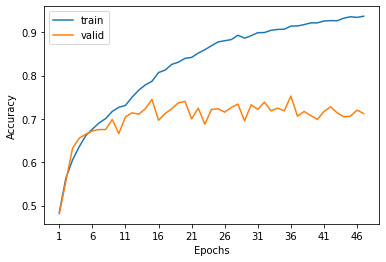

In [17]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# check model size
# summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'sgd', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b0')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

### freeze not good!

In [18]:
# # clear memory
# gc.collect()
# torch.cuda.empty_cache()

# # sub map or super map
# # NUM_FINETUNE_CLASSES = len(sub_map)
# NUM_FINETUNE_CLASSES = len(super_map)
# model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# # initialize the output layer
# nn.init.xavier_normal_(model.classifier.weight)
# nn.init.zeros_(model.classifier.bias)

# # freeze the pretrained layer
# freeze_pretrained_layers(model)

# # check model size
# # summary(model,input_size = (32, 3, 224, 224))

# # Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Send the model to GPU
# model_ft = model.to(device)

# # choose one of "sgd", "adam", "adamW"
# optimizer = select_optimizer(model_ft, 'sgd', lr=0.001)

# # Setup the loss fxn
# criterion = nn.CrossEntropyLoss()
# dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# # Train and evaluate
# model_ft, val_hist, train_hist = train_model(model_ft, dataloaders_dict, criterion, 
#                              optimizer, num_epochs=25)

# # save model to output dir
# save_model(out_super_dir, model_ft, 'efficientnet_b0_freeze')

Epoch 0/24
----------
train Loss: 1.0742 Acc: 0.4313
val Loss: 1.5781 Acc: 0.3941

Epoch 1/24
----------
train Loss: 1.0559 Acc: 0.4431
val Loss: 1.5065 Acc: 0.4019

Epoch 2/24
----------
train Loss: 1.0496 Acc: 0.4445
val Loss: 1.5010 Acc: 0.4019

Epoch 3/24
----------
train Loss: 1.0448 Acc: 0.4474
val Loss: 1.5007 Acc: 0.4065

Epoch 4/24
----------
train Loss: 1.0408 Acc: 0.4491
val Loss: 1.5082 Acc: 0.4080

Epoch 5/24
----------
train Loss: 1.0373 Acc: 0.4512
val Loss: 1.5276 Acc: 0.4142

Epoch 6/24
----------
train Loss: 1.0342 Acc: 0.4518
val Loss: 1.5443 Acc: 0.4111

Epoch 7/24
----------
train Loss: 1.0315 Acc: 0.4549
val Loss: 1.5582 Acc: 0.4219

Epoch 8/24
----------
train Loss: 1.0289 Acc: 0.4597
val Loss: 1.5694 Acc: 0.4266

Epoch 9/24
----------
train Loss: 1.0266 Acc: 0.4626
val Loss: 1.5782 Acc: 0.4266

Epoch 10/24
----------
train Loss: 1.0244 Acc: 0.4673
val Loss: 1.5848 Acc: 0.4312

Epoch 11/24
----------
train Loss: 1.0223 Acc: 0.4717
val Loss: 1.5897 Acc: 0.4297

Ep

NameError: name 'out_dir' is not defined

## efficient net b1

Epoch 0/99
----------
train Loss: 1.2336 Acc: 0.4602
val Loss: 3.0928 Acc: 0.4760

Epoch 1/99
----------
train Loss: 1.0889 Acc: 0.5223
val Loss: 1.1301 Acc: 0.5533

Epoch 2/99
----------
train Loss: 0.9954 Acc: 0.5590
val Loss: 1.0335 Acc: 0.6136

Epoch 3/99
----------
train Loss: 0.9096 Acc: 0.6045
val Loss: 1.3062 Acc: 0.6383

Epoch 4/99
----------
train Loss: 0.8608 Acc: 0.6368
val Loss: 1.6491 Acc: 0.6507

Epoch 5/99
----------
train Loss: 0.8414 Acc: 0.6483
val Loss: 1.8652 Acc: 0.6600

Epoch 6/99
----------
train Loss: 0.8168 Acc: 0.6568
val Loss: 1.4050 Acc: 0.6785

Epoch 7/99
----------
train Loss: 0.7979 Acc: 0.6617
val Loss: 0.9518 Acc: 0.6832

Epoch 8/99
----------
train Loss: 0.7849 Acc: 0.6690
val Loss: 1.3322 Acc: 0.6739

Epoch 9/99
----------
train Loss: 0.7511 Acc: 0.6830
val Loss: 1.9193 Acc: 0.6646

Epoch 10/99
----------
train Loss: 0.7413 Acc: 0.6896
val Loss: 1.1424 Acc: 0.7063

Epoch 11/99
----------
train Loss: 0.7351 Acc: 0.6958
val Loss: 0.6561 Acc: 0.7280

Ep

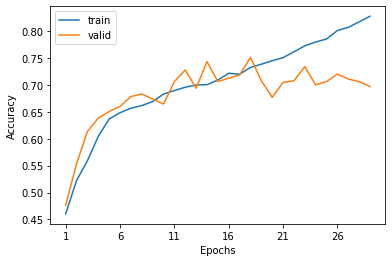

In [18]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b1', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# check model size
# summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'sgd', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b1')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b2

Epoch 0/99
----------
train Loss: 1.2241 Acc: 0.4619
val Loss: 2.2396 Acc: 0.5023

Epoch 1/99
----------
train Loss: 1.0425 Acc: 0.5482
val Loss: 1.8827 Acc: 0.6074

Epoch 2/99
----------
train Loss: 0.9692 Acc: 0.5857
val Loss: 2.1833 Acc: 0.4961

Epoch 3/99
----------
train Loss: 0.9298 Acc: 0.6007
val Loss: 1.2163 Acc: 0.5688

Epoch 4/99
----------
train Loss: 0.8797 Acc: 0.6220
val Loss: 2.3319 Acc: 0.6198

Epoch 5/99
----------
train Loss: 0.8718 Acc: 0.6236
val Loss: 1.0481 Acc: 0.6553

Epoch 6/99
----------
train Loss: 0.8679 Acc: 0.6303
val Loss: 0.8456 Acc: 0.6847

Epoch 7/99
----------
train Loss: 0.8180 Acc: 0.6521
val Loss: 1.0882 Acc: 0.6770

Epoch 8/99
----------
train Loss: 0.7943 Acc: 0.6640
val Loss: 1.0843 Acc: 0.6847

Epoch 9/99
----------
train Loss: 0.7797 Acc: 0.6725
val Loss: 1.1824 Acc: 0.6522

Epoch 10/99
----------
train Loss: 0.7701 Acc: 0.6762
val Loss: 0.9769 Acc: 0.7017

Epoch 11/99
----------
train Loss: 0.7479 Acc: 0.6876
val Loss: 0.9034 Acc: 0.7079

Ep

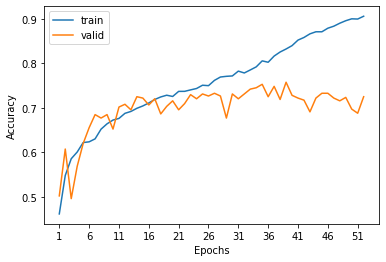

In [19]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b2', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# check model size
# summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'sgd', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b2')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b3

Epoch 0/99
----------
train Loss: 1.3796 Acc: 0.4609
val Loss: 48.2776 Acc: 0.4884

Epoch 1/99
----------
train Loss: 1.1279 Acc: 0.5127
val Loss: 4.0898 Acc: 0.5039

Epoch 2/99
----------
train Loss: 1.0517 Acc: 0.5455
val Loss: 1.5466 Acc: 0.5765

Epoch 3/99
----------
train Loss: 0.9688 Acc: 0.5846
val Loss: 5.6004 Acc: 0.5703

Epoch 4/99
----------
train Loss: 0.9271 Acc: 0.6167
val Loss: 9.3136 Acc: 0.6074

Epoch 5/99
----------
train Loss: 0.8939 Acc: 0.6255
val Loss: 1.1722 Acc: 0.6522

Epoch 6/99
----------
train Loss: 0.8581 Acc: 0.6486
val Loss: 1.7363 Acc: 0.5889

Epoch 7/99
----------
train Loss: 0.8290 Acc: 0.6590
val Loss: 3.1232 Acc: 0.6244

Epoch 8/99
----------
train Loss: 0.8064 Acc: 0.6604
val Loss: 3.1938 Acc: 0.6569

Epoch 9/99
----------
train Loss: 0.8037 Acc: 0.6743
val Loss: 2.6249 Acc: 0.6615

Epoch 10/99
----------
train Loss: 0.7862 Acc: 0.6753
val Loss: 1.8847 Acc: 0.6569

Epoch 11/99
----------
train Loss: 0.7698 Acc: 0.6849
val Loss: 1.8659 Acc: 0.6692

E

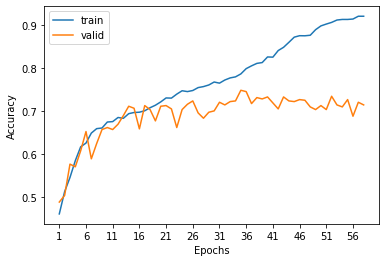

In [20]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b3', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# check model size
# summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'sgd', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                             optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b3')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b4

Epoch 0/99
----------
train Loss: 1.2373 Acc: 0.6053
val Loss: 2.5569 Acc: 0.7125

Epoch 1/99
----------
train Loss: 0.7291 Acc: 0.6992
val Loss: 0.7664 Acc: 0.7048

Epoch 2/99
----------
train Loss: 0.6907 Acc: 0.7224
val Loss: 0.6174 Acc: 0.7311

Epoch 3/99
----------
train Loss: 0.6308 Acc: 0.7466
val Loss: 0.6613 Acc: 0.7434

Epoch 4/99
----------
train Loss: 0.6222 Acc: 0.7472
val Loss: 0.6243 Acc: 0.7388

Epoch 5/99
----------
train Loss: 0.6188 Acc: 0.7526
val Loss: 0.6235 Acc: 0.7527

Epoch 6/99
----------
train Loss: 0.6116 Acc: 0.7533
val Loss: 0.6335 Acc: 0.7311

Epoch 7/99
----------
train Loss: 0.6093 Acc: 0.7528
val Loss: 0.5670 Acc: 0.7651

Epoch 8/99
----------
train Loss: 0.5402 Acc: 0.7815
val Loss: 0.6422 Acc: 0.7342

Epoch 9/99
----------
train Loss: 0.5123 Acc: 0.7960
val Loss: 0.6302 Acc: 0.7233

Epoch 10/99
----------
train Loss: 0.5085 Acc: 0.7956
val Loss: 0.5985 Acc: 0.7481

Epoch 11/99
----------
train Loss: 0.4792 Acc: 0.8101
val Loss: 0.5988 Acc: 0.7573

Ep

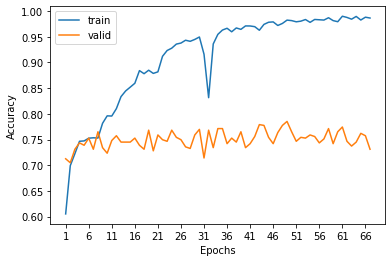

In [21]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b4', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b4')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b5

Epoch 0/99
----------
train Loss: 1.3640 Acc: 0.5593
val Loss: 6.2033 Acc: 0.6445

Epoch 1/99
----------
train Loss: 0.7481 Acc: 0.6874
val Loss: 0.9259 Acc: 0.7388

Epoch 2/99
----------
train Loss: 0.6999 Acc: 0.7068
val Loss: 1.4420 Acc: 0.7017

Epoch 3/99
----------
train Loss: 0.6556 Acc: 0.7297
val Loss: 0.6772 Acc: 0.7512

Epoch 4/99
----------
train Loss: 0.6067 Acc: 0.7546
val Loss: 0.6356 Acc: 0.7620

Epoch 5/99
----------
train Loss: 0.6031 Acc: 0.7581
val Loss: 0.6332 Acc: 0.7403

Epoch 6/99
----------
train Loss: 0.5872 Acc: 0.7583
val Loss: 0.5801 Acc: 0.7805

Epoch 7/99
----------
train Loss: 0.5551 Acc: 0.7761
val Loss: 0.5734 Acc: 0.7697

Epoch 8/99
----------
train Loss: 0.5605 Acc: 0.7766
val Loss: 0.6203 Acc: 0.7620

Epoch 9/99
----------
train Loss: 0.5237 Acc: 0.7884
val Loss: 0.6023 Acc: 0.7743

Epoch 10/99
----------
train Loss: 0.5169 Acc: 0.7938
val Loss: 0.5778 Acc: 0.7697

Epoch 11/99
----------
train Loss: 0.4767 Acc: 0.8159
val Loss: 0.5865 Acc: 0.7620

Ep

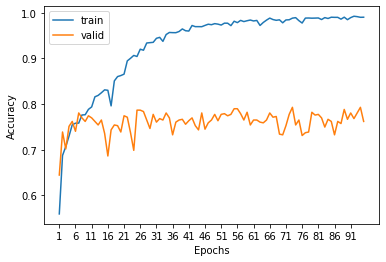

In [22]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b5', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b5')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b6

Epoch 0/99
----------
train Loss: 1.4108 Acc: 0.5212
val Loss: 1.3564 Acc: 0.4838

Epoch 1/99
----------
train Loss: 0.7919 Acc: 0.6655
val Loss: 0.7744 Acc: 0.6940

Epoch 2/99
----------
train Loss: 0.6944 Acc: 0.7197
val Loss: 0.7950 Acc: 0.6955

Epoch 3/99
----------
train Loss: 0.6425 Acc: 0.7442
val Loss: 1.0010 Acc: 0.7218

Epoch 4/99
----------
train Loss: 0.6124 Acc: 0.7550
val Loss: 0.6108 Acc: 0.7388

Epoch 5/99
----------
train Loss: 0.5830 Acc: 0.7731
val Loss: 0.8407 Acc: 0.7094

Epoch 6/99
----------
train Loss: 0.6144 Acc: 0.7553
val Loss: 0.6823 Acc: 0.7280

Epoch 7/99
----------
train Loss: 0.5980 Acc: 0.7642
val Loss: 0.7033 Acc: 0.7187

Epoch 8/99
----------
train Loss: 0.6513 Acc: 0.7375
val Loss: 0.8476 Acc: 0.6785

Epoch 9/99
----------
train Loss: 0.6893 Acc: 0.7189
val Loss: 0.7414 Acc: 0.7589

Epoch 10/99
----------
train Loss: 0.6106 Acc: 0.7547
val Loss: 0.6229 Acc: 0.7589

Epoch 11/99
----------
train Loss: 0.5788 Acc: 0.7682
val Loss: 0.7456 Acc: 0.7342

Ep

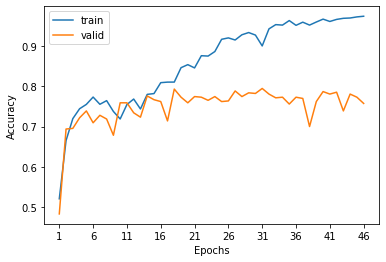

In [39]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b6', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs, patience=10)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b6')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## efficient net b7

In [40]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('efficientnet_b7', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'efficientnet_b7')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

Epoch 0/99
----------
train Loss: 1.3807 Acc: 0.5486
val Loss: 0.9802 Acc: 0.6553

Epoch 1/99
----------
train Loss: 0.7551 Acc: 0.6906
val Loss: 0.7589 Acc: 0.6708

Epoch 2/99
----------
train Loss: 0.6703 Acc: 0.7319
val Loss: 0.7307 Acc: 0.7094

Epoch 3/99
----------
train Loss: 0.6166 Acc: 0.7546
val Loss: 0.6251 Acc: 0.7357

Epoch 4/99
----------
train Loss: 0.6102 Acc: 0.7559
val Loss: 0.7096 Acc: 0.7496

Epoch 5/99
----------
train Loss: 0.5698 Acc: 0.7694
val Loss: 0.6615 Acc: 0.7249

Epoch 6/99
----------
train Loss: 0.5455 Acc: 0.7838
val Loss: 0.6382 Acc: 0.7543

Epoch 7/99
----------
train Loss: 0.5845 Acc: 0.7672
val Loss: 0.6274 Acc: 0.7450

Epoch 8/99
----------
train Loss: 0.6256 Acc: 0.7463
val Loss: 0.7404 Acc: 0.6847

Epoch 9/99
----------
train Loss: 0.6403 Acc: 0.7368
val Loss: 0.8632 Acc: 0.6955

Epoch 10/99
----------
train Loss: 0.5916 Acc: 0.7658
val Loss: 0.6249 Acc: 0.7481

Epoch 11/99
----------
train Loss: 0.5593 Acc: 0.7779
val Loss: 0.6388 Acc: 0.7512

Ep

TypeError: plot_train_val_acc() takes 3 positional arguments but 4 were given

## CoAtNet

/home/ecbm4040/envTF24/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0/99
----------
train Loss: 0.7788 Acc: 0.6709
val Loss: 0.7141 Acc: 0.7063

Epoch 1/99
----------
train Loss: 0.6494 Acc: 0.7289
val Loss: 0.7224 Acc: 0.6723

Epoch 2/99
----------
train Loss: 0.6086 Acc: 0.7516
val Loss: 0.6246 Acc: 0.7295

Epoch 3/99
----------
train Loss: 0.5727 Acc: 0.7642
val Loss: 0.6213 Acc: 0.7326

Epoch 4/99
----------
train Loss: 0.5401 Acc: 0.7806
val Loss: 0.6121 Acc: 0.7264

Epoch 5/99
----------
train Loss: 0.5152 Acc: 0.7923
val Loss: 0.5830 Acc: 0.7573

Epoch 6/99
----------
train Loss: 0.5045 Acc: 0.7968
val Loss: 0.6028 Acc: 0.7543

Epoch 7/99
----------
train Loss: 0.4788 Acc: 0.8091
val Loss: 0.6428 Acc: 0.7326

Epoch 8/99
----------
train Loss: 0.4463 Acc: 0.8233
val Loss: 0.6159 Acc: 0.7589

Epoch 9/99
----------
train Loss: 0.4270 Acc: 0.8302
val Loss: 0.6384 Acc: 0.7512

Epoch 10/99
----------
train Loss: 0.4591 Acc: 0.8163
val Loss: 0.6042 Acc: 0.7589

Epoch 11/99
----------
train Loss: 0.4082 Acc: 0.8396
val Loss: 0.6593 Acc: 0.7604

Ep

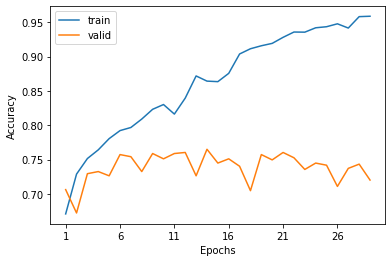

In [17]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(super_map)
model = timm.create_model('coatnet_bn_0_rw_224', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)
summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_super_loader, "val": val_super_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs)

# save model to output dir
path = save_model(out_super_dir, model_ft, 'coatnet_bn_0_rw_224')

# generate acc and f1 score
get_test_result(model_ft, test_super_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

# sub label

Epoch 0/99
----------
train Loss: 4.1781 Acc: 0.0689
val Loss: 3.9009 Acc: 0.0825

Epoch 1/99
----------
train Loss: 3.7000 Acc: 0.1077
val Loss: 5.0738 Acc: 0.1208

Epoch 2/99
----------
train Loss: 3.4866 Acc: 0.1390
val Loss: 4.4517 Acc: 0.1119

Epoch 3/99
----------
train Loss: 3.3606 Acc: 0.1594
val Loss: 4.1750 Acc: 0.1399

Epoch 4/99
----------
train Loss: 3.1919 Acc: 0.1896
val Loss: 3.3646 Acc: 0.1753

Epoch 5/99
----------
train Loss: 3.0064 Acc: 0.2202
val Loss: 3.3611 Acc: 0.1988

Epoch 6/99
----------
train Loss: 2.8498 Acc: 0.2492
val Loss: 3.6653 Acc: 0.1870

Epoch 7/99
----------
train Loss: 2.9193 Acc: 0.2435
val Loss: 5.9100 Acc: 0.1252

Epoch 8/99
----------
train Loss: 2.8623 Acc: 0.2554
val Loss: 4.4403 Acc: 0.1694

Epoch 9/99
----------
train Loss: 2.6470 Acc: 0.2945
val Loss: 5.4795 Acc: 0.2150

Epoch 10/99
----------
train Loss: 2.4937 Acc: 0.3209
val Loss: 3.6805 Acc: 0.1708

Epoch 11/99
----------
train Loss: 2.0488 Acc: 0.4186
val Loss: 4.0675 Acc: 0.1797

Ep

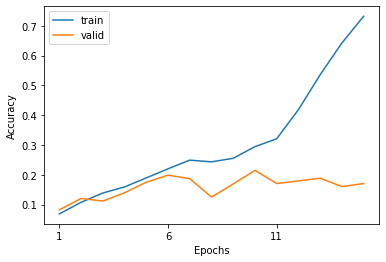

In [18]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(sub_map)
model = timm.create_model('efficientnet_b5', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_sub_loader, "val": val_sub_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs, patience=5)

# save model to output dir
path = save_model(out_sub_dir, model_ft, 'efficientnet_b5')

# generate acc and f1 score
get_test_result(model_ft, test_sub_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

## CoatNet

/home/ecbm4040/envTF24/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0/99
----------
train Loss: 3.8451 Acc: 0.1090
val Loss: 3.4240 Acc: 0.1767

Epoch 1/99
----------
train Loss: 3.4626 Acc: 0.1523
val Loss: 3.4260 Acc: 0.1708

Epoch 2/99
----------
train Loss: 3.3049 Acc: 0.1773
val Loss: 3.3329 Acc: 0.1870

Epoch 3/99
----------
train Loss: 3.2121 Acc: 0.1927
val Loss: 3.3969 Acc: 0.1782

Epoch 4/99
----------
train Loss: 3.1247 Acc: 0.2008
val Loss: 3.4941 Acc: 0.1767

Epoch 5/99
----------
train Loss: 3.0763 Acc: 0.2129
val Loss: 3.2245 Acc: 0.2091

Epoch 6/99
----------
train Loss: 2.9518 Acc: 0.2361
val Loss: 3.4813 Acc: 0.1973

Epoch 7/99
----------
train Loss: 2.9231 Acc: 0.2435
val Loss: 3.4540 Acc: 0.1870

Epoch 8/99
----------
train Loss: 2.8958 Acc: 0.2486
val Loss: 3.2621 Acc: 0.2047

Epoch 9/99
----------
train Loss: 2.9247 Acc: 0.2444
val Loss: 3.2253 Acc: 0.2047

Epoch 10/99
----------
train Loss: 2.7919 Acc: 0.2636
val Loss: 3.4086 Acc: 0.2062

Epoch 11/99
----------
train Loss: 2.6955 Acc: 0.2820
val Loss: 3.4747 Acc: 0.2106

Ep

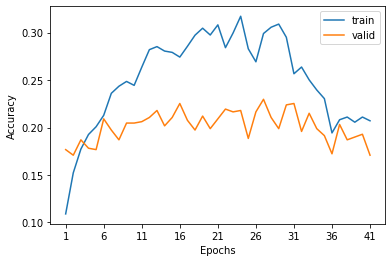

In [18]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# sub map or super map
NUM_FINETUNE_CLASSES = len(sub_map)
model = timm.create_model('coatnet_bn_0_rw_224', pretrained=False, num_classes=NUM_FINETUNE_CLASSES)
summary(model,input_size = (32, 3, 224, 224))

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model.to(device)

# choose one of "sgd", "adam", "adamW"
optimizer = select_optimizer(model_ft, 'adam', lr=0.001)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
dataloaders_dict = {"train": train_sub_loader, "val": val_sub_loader}

# Train and evaluate
epochs = 100
model_ft, train_hist, val_hist = train_model(model_ft, dataloaders_dict, criterion, 
                                     optimizer, num_epochs=epochs)

# save model to output dir
path = save_model(out_sub_dir, model_ft, 'coatnet_bn_0_rw_224')  # coatnet_bn_0_rw_224

# generate acc and f1 score
get_test_result(model_ft, test_sub_loader)

# plot the whole process
plot_train_val_acc(path[:-4], train_hist, val_hist)

<!-- coatnet_0_224
coatnet_0_rw_224
coatnet_bn_0_rw_224 -->

# generate test result for voting

In [19]:
from os import listdir
from os.path import isfile, join
import cv2

# get the filename
test_submit_dir = "./Data/test_shuffle"
all_imgs = [f for f in listdir(test_submit_dir) if isfile(join(test_submit_dir, f))]

# sort them
from natsort import natsorted
all_imgs = natsorted(all_imgs)

In [20]:
# test set
class Test_Dataset(Dataset):
    def __init__(self, all_imgs, transform=None):
        # torch vision 
        self.imgs = all_imgs
        
        # transform
        self.transform = transform
        
    def __len__(self): 
        return len(self.imgs)    
    
    def __getitem__(self, index):
        # read the image and label
        path = os.path.join("./Data/test_shuffle", self.imgs[index])
        img = Image.open(path)
        
        if self.transform:
            img = self.transform(img)
            
        return img, self.imgs[index]

# test set
test_submit_set = Test_Dataset(all_imgs, img_transform)

# data loader
test_submit_loader = DataLoader(test_submit_set, batch_size=16, shuffle=False, num_workers=2)

In [21]:
# get submit result
def get_submit_result(model, loader):
    outputs = np.array([])
    img_names = []
    
    model.eval()
    for img, img_name in loader:
        img = img.to(device)

        with torch.no_grad():
            out = model(img)
            _, preds = torch.max(out, 1)
            
        outputs = np.append(outputs, preds.cpu().detach().numpy())
        # check whether they are in order
        # print(img_name)
        

    return outputs

## Super

In [24]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# reload model
PATH = "./Output/model_super/12-17-2022 21:59:59 efficientnet_b5.pth"
model_CoAtNet = timm.create_model('efficientnet_b5', pretrained=False, num_classes=3)
model_CoAtNet.load_state_dict(torch.load(PATH))

# load to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CoAtNet = model_CoAtNet.to(device)

# get outputs
outputs = get_submit_result(model_CoAtNet, test_submit_loader)
outputs = outputs.astype(int)

# save to csv file
df = pd.DataFrame(outputs, columns = ['predictions'])
df.to_csv(os.path.join('super_result_EfficientNet_b5.csv'))

In [25]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# reload model
PATH = "./Output/model_super/12-19-2022 09:23:11 coatnet_bn_0_rw_224.pth"
model_CoAtNet = timm.create_model('coatnet_bn_0_rw_224', pretrained=False, num_classes=3)
model_CoAtNet.load_state_dict(torch.load(PATH))

# load to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CoAtNet = model_CoAtNet.to(device)

# get outputs
outputs = get_submit_result(model_CoAtNet, test_submit_loader)
outputs = outputs.astype(int)

# save to csv file
df = pd.DataFrame(outputs, columns = ['predictions'])
df.to_csv(os.path.join('super_result_CoAtNet.csv'))

##  Sub 

In [26]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# reload model
PATH = "./Output/model_sub/12-19-2022 10:26:21 efficientnet_b5.pth"
model_CoAtNet = timm.create_model('efficientnet_b5', pretrained=False, num_classes=90)
model_CoAtNet.load_state_dict(torch.load(PATH))

# load to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CoAtNet = model_CoAtNet.to(device)

# get outputs
outputs = get_submit_result(model_CoAtNet, test_submit_loader)
outputs = outputs.astype(int)

# save to csv file
df = pd.DataFrame(outputs, columns = ['predictions'])
df.to_csv(os.path.join('sub_result_EfficientNet_b5.csv'))

In [27]:
# clear memory
gc.collect()
torch.cuda.empty_cache()

# reload model
PATH = "./Output/model_sub/12-19-2022 04:34:46 coatnet_bn_0_rw_224.pth"
model_CoAtNet = timm.create_model('coatnet_bn_0_rw_224', pretrained=False, num_classes=90)
model_CoAtNet.load_state_dict(torch.load(PATH))

# load to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CoAtNet = model_CoAtNet.to(device)

# get outputs
outputs = get_submit_result(model_CoAtNet, test_submit_loader)
outputs = outputs.astype(int)

# save to csv file
df = pd.DataFrame(outputs, columns = ['predictions'])
df.to_csv(os.path.join('sub_result_CoAtNet.csv'))